In [2]:
#https://www.kaggle.com/muonneutrino/wikipedia-traffic-data-exploration
#fill nan values with 0 upon importing data, since data doesn't distinguish between 0 and missing
#to save memory, downcast data to integers (keep in mind predictions will prob be floating point)
#parse out the language of each url, and plot total views by language
#some of these won't have a language, so label them as na
#plot each language on its own, show fourier transform for each
#plot views for some random pages
#for each language, find the top visited pages
#create ARIMA predictions for pages wth very high viewcount

In [121]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import seaborn as sns
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm
import warnings
#ignore the warnings about not having different language fonts available 
warnings.filterwarnings(action='ignore') 

### Data Exploration and Processing

In [4]:
orig_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_1.csv')
key = pd.read_csv('/Users/christinejiang/Documents/Python/data/key_1.csv')
submission = pd.read_csv('/Users/christinejiang/Documents/Python/data/sample_submission_1.csv')

In [5]:
train = orig_train.fillna(0)

In [6]:
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast = 'integer')

In [7]:
def find_lang(page):
    match = re.search('[a-z][a-z].wikipedia.org', page)
    if match:
        return match.group(0)[0:2]
    return 'na'

def find_article(page):
    match = re.search('[a-z][a-z].wikipedia.org.', page)
    if match:
        article_end = match.start()-1
        return(page[0:article_end])
    return 'na'

def find_access(page):
    match = re.search('.*.wikipedia.org.', page)
    if match:
        access_start = match.end()
        return(page[access_start:])
    return 'na'

train['Language'] = train['Page'].map(find_lang)
train['Article'] = train['Page'].map(find_article)
train['Access'] = train['Page'].map(find_access)

In [8]:
dates = train.iloc[:,1:551]
labels = train[['Article','Language','Access','Page']]
newtrain = pd.concat([labels, dates], axis = 1)

In [9]:
display(newtrain.head(2))
newtrain['Language'].value_counts().sort_values(ascending=False)

,Article,Language,Access,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access_spider,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,...,32,63,15,26,14,20,22,19,18,20
1,2PM,zh,all-access_spider,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,...,17,42,28,15,9,30,52,45,26,20


en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: Language, dtype: int64

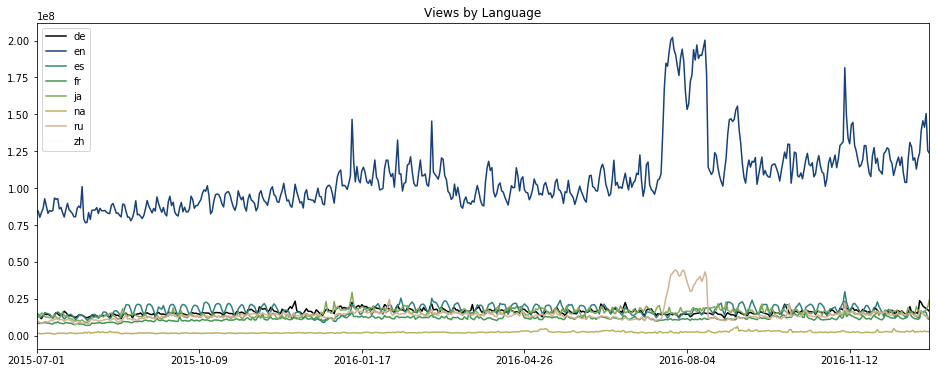

In [10]:
def plot_groups(df, group):
    group = df.groupby(group).sum().reset_index()
    transpose = group.T
    transpose = transpose.rename(columns = transpose.iloc[0]).drop(transpose.index[0])
    figure = transpose.plot(figsize=(16,6), use_index = True, colormap = "gist_earth")
    title=plt.title('Views by Language')
    return transpose

transposed = plot_groups(newtrain, 'Language')

In [11]:
languages = newtrain['Language'].unique()
indices = np.random.randint(1,1400,size=3)
num_results = len(indices)
print(indices)

[ 851  878 1079]


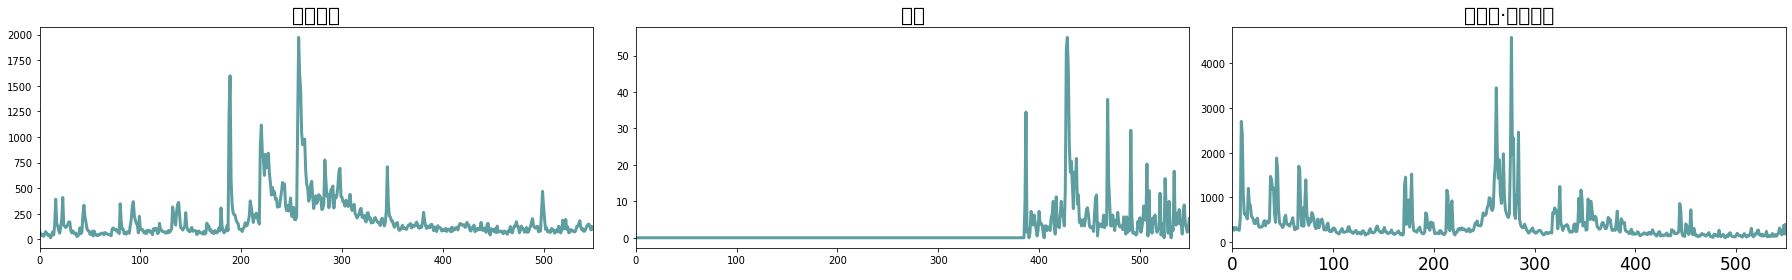

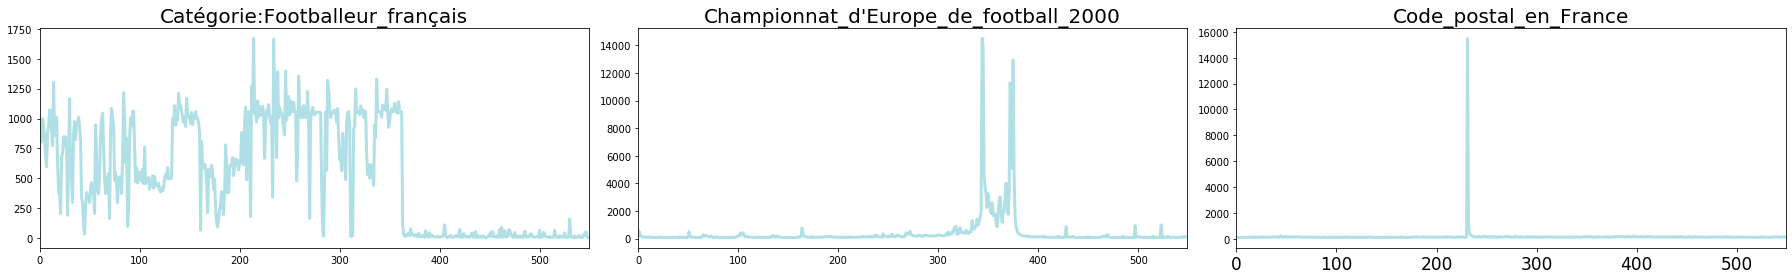

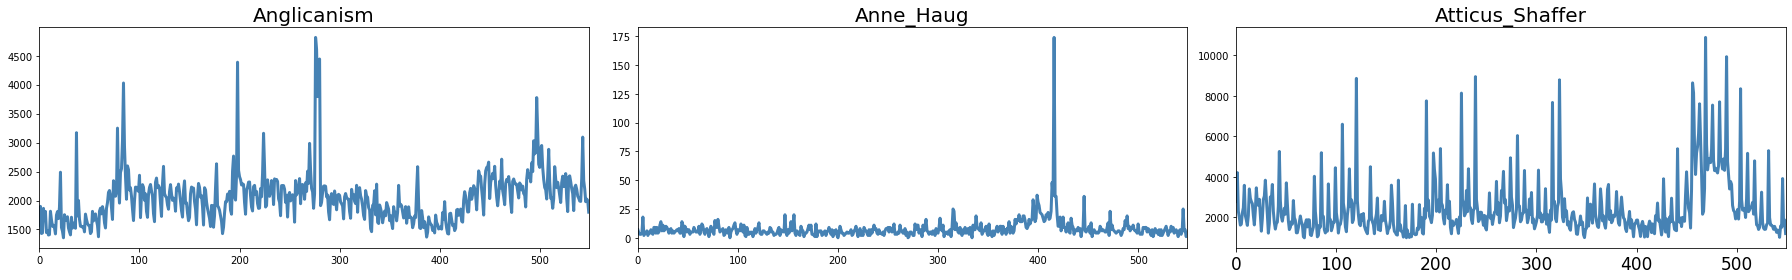

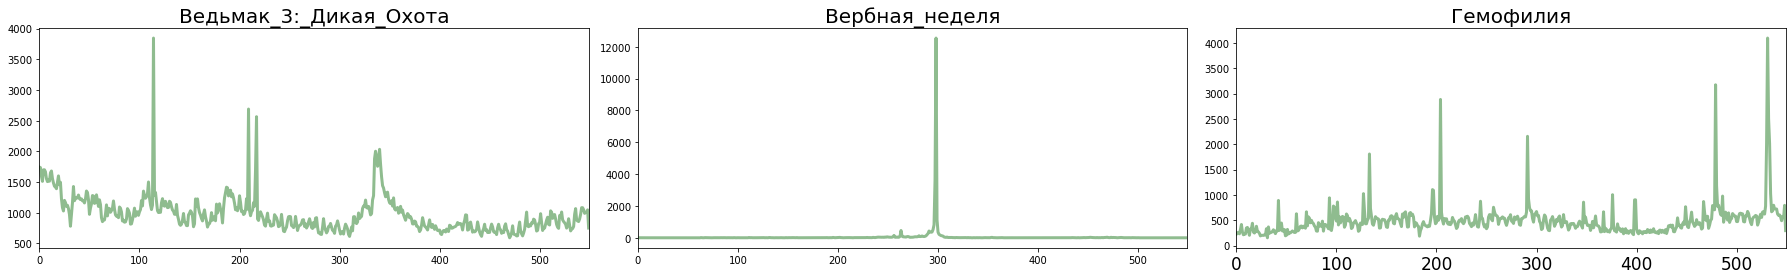

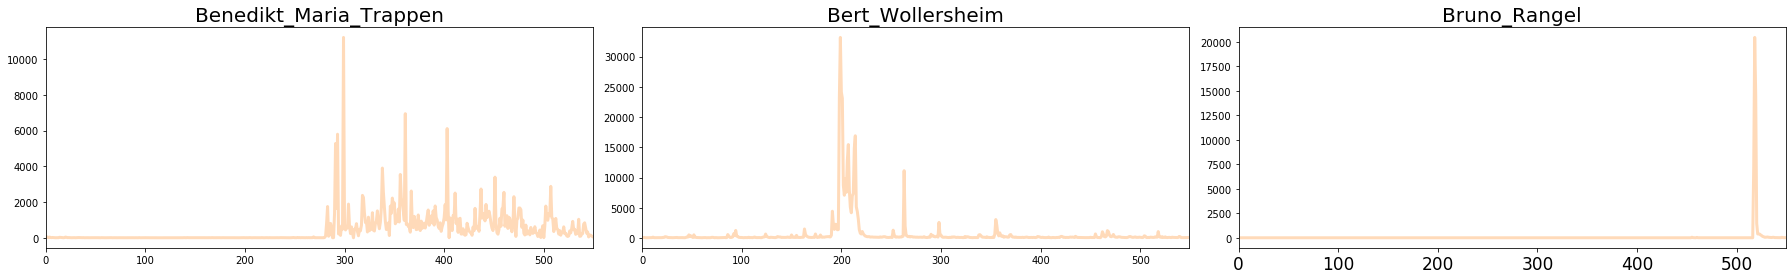

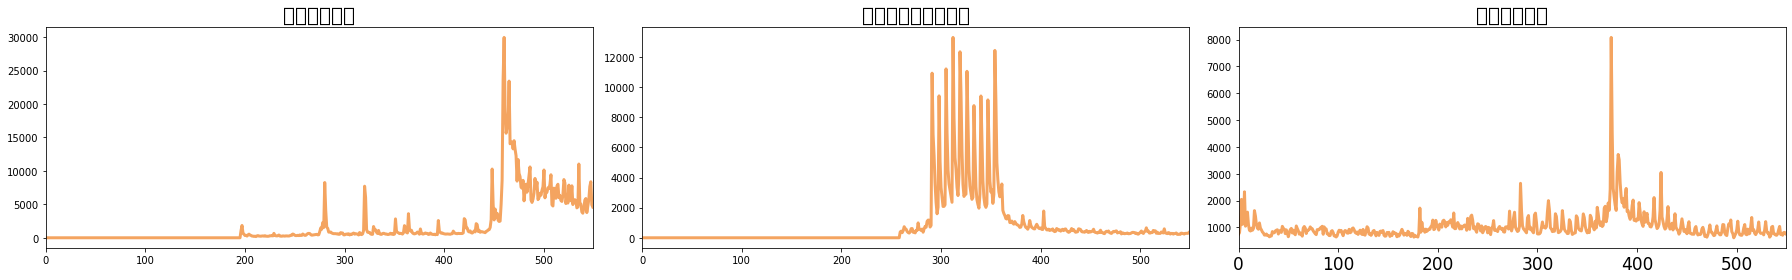

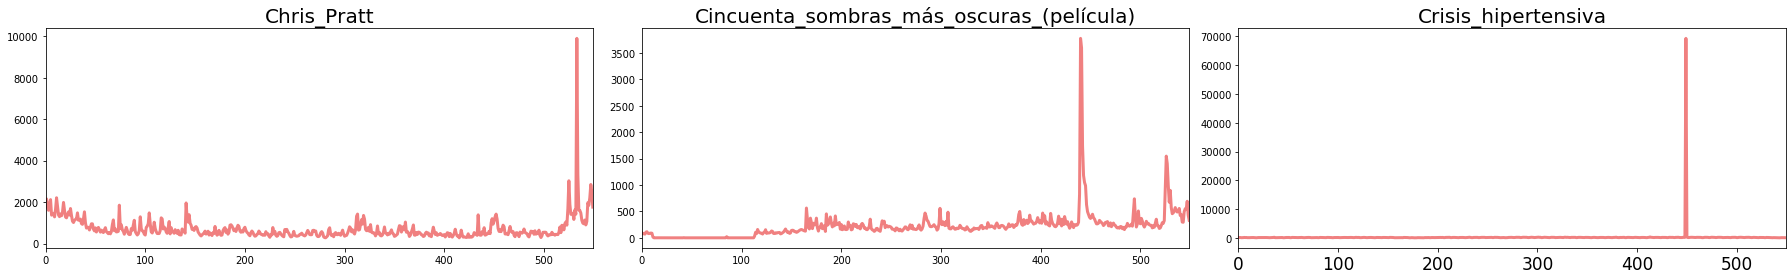

In [12]:
#graph 3 random web pages from each language
colors = ['cadetblue','powderblue','steelblue','yellowgreen','darkseagreen','peachpuff','sandybrown','lightcoral']
dataframedict = {}
for i,language in enumerate(languages):
    dataframedict[language] = newtrain[newtrain['Language']==language]
    if language != 'na':
        langcolor = colors[i]
        fig, subaxes = plt.subplots(1,num_results,figsize=[25,4])
        pivottable = dataframedict[language].pivot_table(columns='Article')
        for i, index in enumerate(indices):
            singlerecord = pivottable.iloc[:,index]
            plt.xticks(fontsize=17)
            sns.tsplot(singlerecord,ax = subaxes[i],color=langcolor, linewidth=3)
            subaxes[i].set_title(singlerecord.name)
            subaxes[i].title.set_size(20)
            #fig.suptitle(language)
            plt.tight_layout()


### Time Series Modeling

In [13]:
#time series
#check if its stationary - mean, variance, and covariance are constant over time
#have to convert series to stationary, otherwise cant apply any time series analysis
#take the difference of the series - lag of n-1 - n
#series.diff(periods=1), can remove the header row since that will have a lag of NaN
#from statsmodels.graphics.tsaplots import plot_acf
#autocorrelation - correlation between original series and its lag (shift numbers down one unit)
#if it decays over time, it is not stationary - it should decay immediately
#adfuller statistic is equal to the t-statistic when conducting OLS for a time series in predicting its difference with one lag

#to do:
#read statsmodel documentation
#read itertools documentation
#better understand AR, MA, ARIMA model and assumptions

#p - how many months of a lag do you want to use for regression (use may to predict june)
#d - order of integration
#q - moving average - number of periods to lag in moving average model

In [46]:
average = dataframedict['zh'].iloc[:,4:].mean()
avg_df = pd.DataFrame(average).rename(columns={0:'Hits'}).set_index(pd.DatetimeIndex(avg_df.index))

stationarity = adfuller(avg_df['Hits'])
print(f'''ADF Statistic: {stationarity[0]}
P-Value: {stationarity[1]}''')
if stationarity[0] < stationarity[4]['5%']:
    print('Stationary')
else:
    print('Not stationary')
    
avg_df.describe().T

ADF Statistic: -1.6684328368686192
P-Value: 0.4474457922931121
Not stationary


,count,mean,std,min,25%,50%,75%,max
Hits,550.0,334.740615,58.394898,178.252249,284.242962,344.065326,372.510941,633.967497


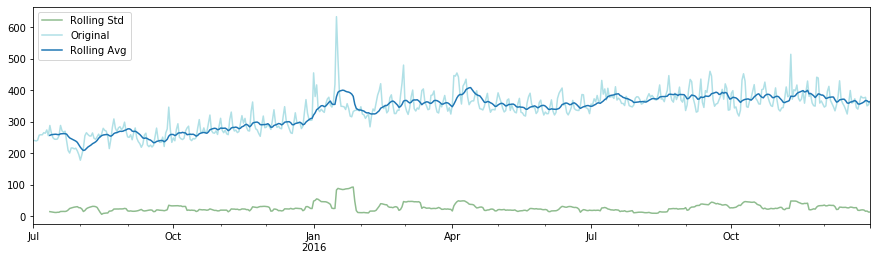

In [87]:
fig, axes = plt.subplots(1,figsize=(15,4))
avg_df.rolling(12).std().plot(color='darkseagreen',ax=axes,label='Test')
avg_df.plot(ax=axes,color='powderblue')
avg_df.rolling(12).mean().plot(ax=axes)
legend = axes.legend(['Rolling Std','Original','Rolling Avg'])

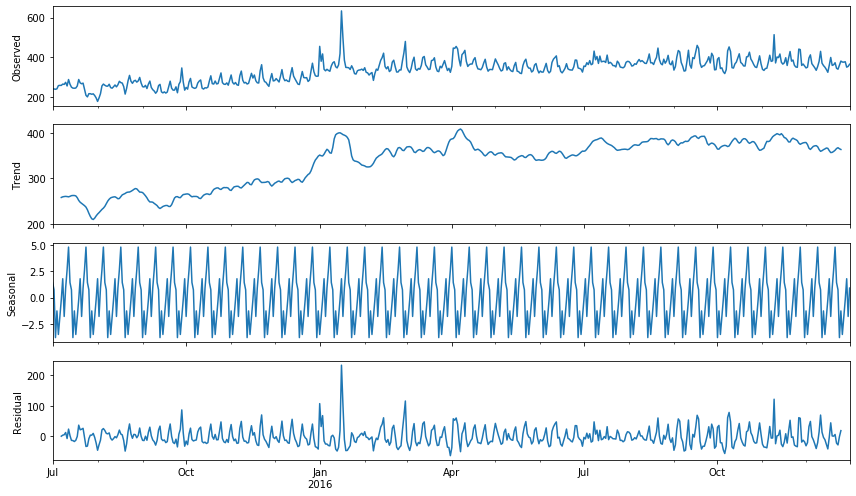

In [93]:
decomp = seasonal_decompose(avg_df,freq=12)
plt.rcParams['figure.figsize']=(12,7)
fig=decomp.plot()

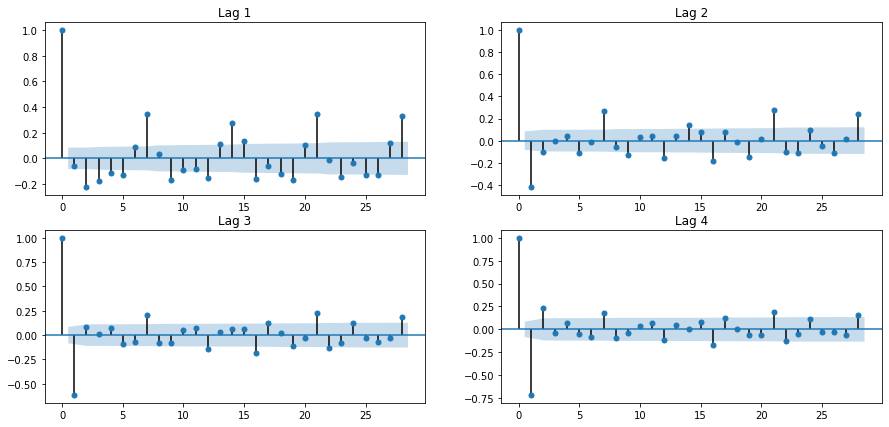

In [122]:
#try q values of 1-4
plt.rcParams['figure.figsize'] = (10,3)

fig, axes = plt.subplots(2,2,figsize=(15,7))
df_lag1=avg_df.diff(periods=1)
fig = plot_acf(df_lag1[1:], ax=axes[0][0], title = 'Lag 1')

df_lag2 = df_lag1.diff(periods=1)
fig = plot_acf(df_lag2[2:], ax=axes[0][1], title = 'Lag 2')

df_lag3 = df_lag2.diff(periods=1)
fig = plot_acf(df_lag3[3:], ax=axes[1][0], title = 'Lag 3')

df_lag4 = df_lag3.diff(periods=1)
fig = plot_acf(df_lag4[4:], ax=axes[1][1], title = 'Lag 4')

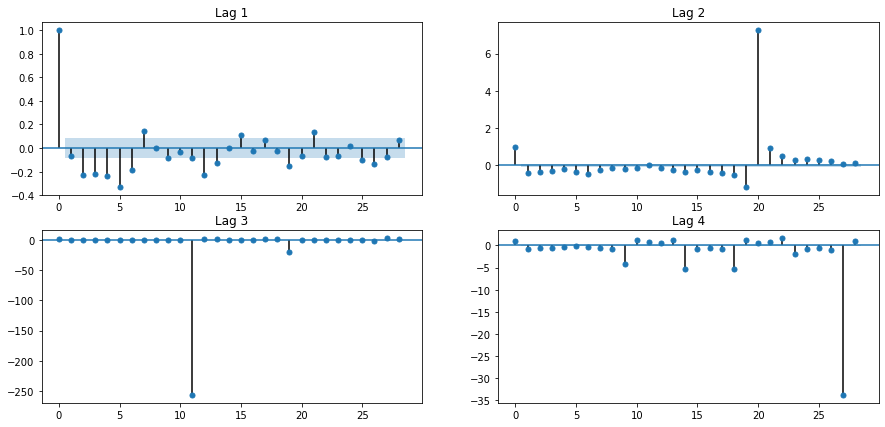

In [123]:
#try q values of 1-7
plt.rcParams['figure.figsize'] = (10,3)

fig, axes = plt.subplots(2,2,figsize=(15,7))
df_lag1=avg_df.diff(periods=1)
fig = plot_pacf(df_lag1[1:], ax=axes[0][0], title = 'Lag 1')

df_lag2 = df_lag1.diff(periods=1)
fig = plot_pacf(df_lag2[2:], ax=axes[0][1], title = 'Lag 2')

df_lag3 = df_lag2.diff(periods=1)
fig = plot_pacf(df_lag3[3:], ax=axes[1][0], title = 'Lag 3')

df_lag4 = df_lag3.diff(periods=1)
fig = plot_pacf(df_lag4[4:], ax=axes[1][1], title = 'Lag 4')

In [171]:
marker = int(avg_df.shape[0]*0.75)
train = avg_df.iloc[0:marker]
test = avg_df.iloc[marker:]

p=q=d=range(0,5)
pdq = list(itertools.product(p,d,q))

aics = []
best_aic = 9999
for param in tqdm(pdq):
    try:
        arima = ARIMA(train, order = param).fit()
        if arima.aic < best_aic:
            aics = ({param: arima.aic})
            best_aic = arima.aic
        if arima.aic == best_aic:
            aics.append({param: arima.aic})
            best_aic = arima.aic            
    except:
        continue

100%|██████████| 125/125 [00:20<00:00,  6.04it/s]


In [189]:
best_arima = ARIMA(train, order = (4,1,4))
predictions = arima.forecast(steps = test.shape[0])
squared_error = mean_squared_error(test, predictions[0])
mean_error = np.sqrt(squared_error)
mean_error

1134.879599387021

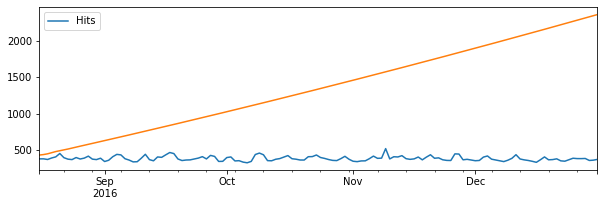

In [195]:
axes = test.plot()
pd.Series(predictions[0], index =test.index).plot(ax=axes)